### Import data

In [1]:
import CSV
using LeastSquaresOptim, DifferentialEquations, DelayDiffEq, DiffEqBase, Optim, Plots, Statistics, DataFrames

function get_data(path_g2, path_total)
    # Import data
    data = CSV.read(path_g2)
    total = CSV.read(path_total)

    # delete the extra index column
    deletecols!(data, 1:2)
    deletecols!(total, 1:2)

    # getting all the 8 trials
    drug = data[1:192, 1:8]
    pop = total[1:192, 1:8]

    # rescaling the experimental data assuming we have 20 initial cells for each trial
    g1 = zeros(size(drug, 1), 8)
    g2 = zeros(size(drug, 1), 8)
    g1_0 = zeros(8)
    g2_0 = zeros(8)

    init_cells = 20.0

    # Unifying the dataset to be all in the unit of [# of cells] at each time point forall the trials for a drug
    for i in 1:8
        pop[:, i] = init_cells*pop[:, i]
        g2[:, i] = 0.01*pop[:, i] .* drug[:, i]
        g1[:, i] = pop[:, i] .- g2[:, i]
        g2_0[i] = init_cells*(drug[1, i]/100.0)
        g1_0[i] = init_cells*(1 - drug[1, i]/100.0)
    end
    return pop, g2, g1, g2_0, g1_0
end

pop, g2, g1, g2_0, g1_0 = get_data("..//data//lap.csv", "..//data//lap_pop.csv");
# i is the number of the column we are using from the data

In [2]:
i = 2
function DDEmodel(du, u, h, p, t)
    du[1] = -p[1]*(h(p, t-p[3])[1]) + 2*p[2]*(h(p, t-p[4])[2]) - p[6]*u[1]
    du[2] = p[1]*(h(p, t-p[3])[1]) - p[2]*(h(p, t-p[4])[2]) - p[7]*u[2]
end

function DDEsolve(pp)
    lags = [pp[3], pp[4]]
    h(p, t) = pp[5]*ones(2)
    t = LinRange(0.0, 95.5, 192)
    tspan = (0.0, 95.5)
    u0 = [g1_0[i], g2_0[i]]
    prob = DDEProblem(DDEmodel, u0, h, tspan, pp; constant_lags = lags)
    solve(prob)
end


p  = [0.0557736, 0.0311629, 1.00062, 5.00084, 17.3839, 0.005907, 0.00194876]
low = [0.001, 0.0005, 0.5, 3.0, 7.0, 0.0001, 0.0001]
upp = [0.1, 0.1, 30.0, 30.0, 100.0, 0.1, 0.1]


par = zeros(7,8)
for j in 1:8
    function resid(pp)
        t = LinRange(0.0, 95.5, 192)
        res = zeros(2, 192)
        params = zeros(8, 7)
        sol = DDEsolve(pp)
        res[1, :] = sol(t, idxs=1).u - g1[:, j]
        res[2, :] = sol(t, idxs=2).u - g2[:, j]
        return res
    end
    results_dde = optimize(resid, p, LevenbergMarquardt(), lower = low, upper = upp)
    par[:, j] = results_dde.minimizer
end 

In [3]:
par[2, :]

8-element Array{Float64,1}:
 0.04806548819895717 
 0.03635156435241236 
 0.1                 
 0.1                 
 0.03169285860421122 
 0.041939775515935765
 0.04539167216972555 
 0.002255319960984529

In [27]:
@. dose_response(x, p) =  p[1] + ((p[2] - p[1]) / (1 + 10^((x - p[3])*p[4])))
p1 = zeros(7, 12)
new_ps = zeros(7, 12)
for k in 1:7
    p1[k, 9:end] = [0.01, 0.35, 40.0, 0.05]
    p1[k, 1:8] = par[k, :]
    b = p1[k, :]
    function res(b)
        xdata = [0.0, 5.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0]
        residue = dose_response(xdata, b[9:end]) - b[1:8]
        return residue
    end
    results = optimize(res, p1[k, :], LevenbergMarquardt())
    new_ps[k, :] = results.minimizer
end

12-element Array{Float64,1}:
  0.2036109534210822   
  0.19413287531179516  
  0.18319732252178178  
  0.1427788613128169   
  0.07081997694982975  
  0.010373176062228996 
  0.002899591266739237 
  0.0028953616389463684
  0.0028953616234055767
  0.24597086996297643  
 31.077233847747042    
  0.021740223656183645 

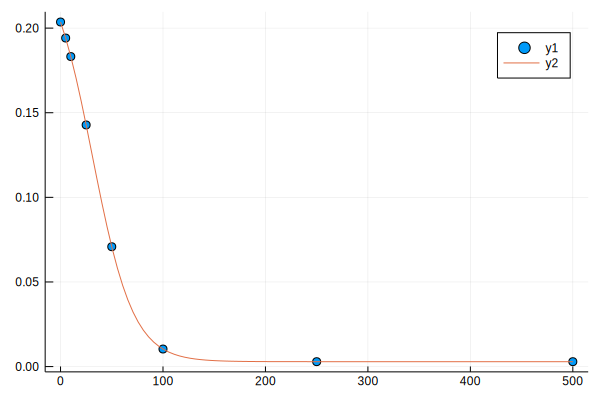

In [34]:
xdata = [0.0, 5.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0]
yd = new_ps[1, 1:8]
para = new_ps[1, 9:end]
xd = LinRange(0.0, 500.0, 100)
est = dose_response(xd, para)
scatter(xdata, yd)
plot!(xd, est)